In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
import bff
import pingouin as pg

# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]


# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 120

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Autosaving every 120 seconds


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

In [10]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("belief2behav.xlsx"), index_col=0)
df.head()

,duration,BeliefPRE1,BeliefPRE2,BeliefPRE3,BeliefPRE4,BeliefPRE5,BeliefPRE6,BeliefPRE7,BeliefPRE8,BehavPRE1,...,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged,BeliefPREi,BeliefPREd,ChoicePREi,ChoicePREd
Response ID,,,,,,,,,,,,,,,,,,,,,
R_xxQrJy9N6AlcPhn,277,51,96,13,99,65,84,97,91,10,...,16.25,8.75,10.75,-79.00,2.5,-2.5,64.75,84.25,13.75,11.25
R_272vAkqsrWHg0By,300,70,70,25,95,84,70,90,30,20,...,25.00,0.00,35.00,-68.50,7.5,-7.5,65.00,68.50,17.50,7.50
R_uxkl7x3kByeIwyR,356,100,100,72,92,72,51,91,81,50,...,25.00,0.00,8.75,-55.75,0.0,0.0,91.00,73.75,25.00,0.00
R_32WL00Xs1xFtRRj,195,30,59,62,35,75,33,36,46,0,...,20.00,5.00,40.75,-20.25,5.0,-5.0,46.50,47.50,15.00,10.00
R_e99UKmrYl7rVOCJ,231,40,54,52,47,89,79,60,60,100,...,25.00,0.00,0.00,13.50,0.0,0.0,48.25,72.00,25.00,0.00


In [14]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
age = df.loc[:, "Age"]
trust = df.loc[:,"TrustScience"]

BeliefPOSTi = df.loc[:,"BeliefPOSTi"]
BeliefPOSTd = df.loc[:,"BeliefPOSTd"]
ChoicePOSTi = df.loc[:,"ChoicePOSTi"]
ChoicePOSTd = df.loc[:,"ChoicePOSTd"]
Bchangei = df.loc[:,"Bchangei"]
Bchanged = df.loc[:,"Bchanged"]
Cchangei = df.loc[:,"Cchangei"]
Cchanged = df.loc[:,"Cchanged"]

partnum = np.arange(trust.size)

In [15]:
# Extract data with df.loc[:,"datastart":"dataend"]
BeliefPRE = df.loc[:, "BeliefPRE1":"BeliefPRE8"]
BeliefPOST = df.loc[:, "BeliefPOST1":"BeliefPOST8"]
ChoicePRE = df.loc[:, "BehavPRE1":"BehavPRE8"]
ChoicePOST = df.loc[:, "BehavPOST1":"BehavPOST8"]
RdeltaB = df.loc[:, "RB1":"RB8"]
RdeltaC = df.loc[:, "RC1":"RC8"]
deltaB = df.loc[:, "Bchange1":"Bchange8"]
deltaC = df.loc[:, "Cchange1":"Cchange8"]

sz = RdeltaB.shape
itemnum = np.arange(sz[-1])
print(sz)

(183, 8)


In [16]:
# Data and row-wise labels first
names = ["BeliefPRE", "BeliefPOST", "ChoicePRE", "ChoicePOST", 'RdeltaB', 'RdeltaC', 'deltaB','deltaC','itemnum', \
         "age", "trust", 'BeliefPOSTi', 'BeliefPOSTd','ChoicePOSTi','ChoicePOSTd','Bchangei','Bchanged','Cchangei','Cchanged',"partnum"]
data_packed = np.broadcast_arrays(BeliefPRE, BeliefPOST, ChoicePRE, ChoicePOST, RdeltaB, RdeltaC, deltaB, deltaC, itemnum)
# Then column-wise labels
cols = [np.tile(a, (sz[1],1)).T for a in [age, trust, BeliefPOSTi, BeliefPOSTd,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
DATA = pd.DataFrame(data=data_unpacked, columns=names)

DATA.head()

,BeliefPRE,BeliefPOST,ChoicePRE,ChoicePOST,RdeltaB,RdeltaC,deltaB,deltaC,itemnum,age,trust,BeliefPOSTi,BeliefPOSTd,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged,partnum
0,51.0,100.0,10.0,20.0,49.0,10.0,49.0,10.0,0.0,31.0,86.0,75.5,5.25,16.25,8.75,10.75,-79.0,2.5,-2.5,0.0
1,96.0,99.0,20.0,30.0,3.0,10.0,3.0,10.0,1.0,31.0,86.0,75.5,5.25,16.25,8.75,10.75,-79.0,2.5,-2.5,0.0
2,13.0,91.0,20.0,10.0,78.0,-10.0,78.0,-10.0,2.0,31.0,86.0,75.5,5.25,16.25,8.75,10.75,-79.0,2.5,-2.5,0.0
3,99.0,12.0,5.0,5.0,-87.0,0.0,-87.0,0.0,3.0,31.0,86.0,75.5,5.25,16.25,8.75,10.75,-79.0,2.5,-2.5,0.0
4,65.0,9.0,5.0,5.0,56.0,0.0,-56.0,0.0,4.0,31.0,86.0,75.5,5.25,16.25,8.75,10.75,-79.0,2.5,-2.5,0.0


In [17]:
# Group and average data within participant
AVDATA = DATA.groupby(["partnum"], as_index=False).mean()
AVDATA.head()

,partnum,BeliefPRE,BeliefPOST,ChoicePRE,ChoicePOST,RdeltaB,RdeltaC,deltaB,deltaC,itemnum,age,trust,BeliefPOSTi,BeliefPOSTd,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged
0,0.0,74.500,40.375,12.5,12.5,44.875,2.5,-34.125,0.0,3.5,31.0,86.0,75.50,5.25,16.25,8.75,10.75,-79.00,2.5,-2.5
1,1.0,66.750,50.000,12.5,12.5,51.750,7.5,-16.750,0.0,3.5,25.0,95.0,100.00,0.00,25.00,0.00,35.00,-68.50,7.5,-7.5
2,2.0,82.375,58.875,12.5,12.5,32.250,0.0,-23.500,0.0,3.5,61.0,100.0,99.75,18.00,25.00,0.00,8.75,-55.75,0.0,0.0
3,3.0,47.000,57.250,12.5,12.5,30.500,5.0,10.250,0.0,3.5,22.0,92.0,87.25,27.25,20.00,5.00,40.75,-20.25,5.0,-5.0
4,4.0,60.125,66.875,12.5,12.5,-6.750,0.0,6.750,0.0,3.5,26.0,61.0,48.25,85.50,25.00,0.00,0.00,13.50,0.0,0.0


In [18]:
%load_ext rpy2.ipython
# %R library(lme4)
%R library(lmerTest)
%R library(MuMIn)


import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [19]:
%Rpush DATA

In [24]:
%Rpull es

R2m = es[0]
R2c = es[1]
f2 = R2m / (1. - R2c)
print("f2 effect size statistic for slope: %.4f" % f2)

#Selya et al, 2012, Frontiers in Psych

f2 effect size statistic for slope: 0.0618


In [25]:
%%R

M <- lmer(RdeltaC ~  RdeltaB + ChoicePRE + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaC ~ RdeltaB + ChoicePRE + (1 | partnum) + (1 | itemnum)
   Data: DATA

REML criterion at convergence: 13262.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7562 -0.3785 -0.1185  0.2574  4.5987 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  14.960   3.868  
 itemnum  (Intercept)   7.747   2.783  
 Residual             483.691  21.993  
Number of obs: 1464, groups:  partnum, 183; itemnum, 8

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.586e+00  1.293e+00 1.146e+01   1.227    0.244    
RdeltaB     1.131e-01  1.473e-02 1.397e+03   7.682 2.94e-14 ***
ChoicePRE   1.546e-01  2.790e-02 1.279e+03   5.542 3.62e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) RdeltB
RdeltaB   -0.318       
ChoicePRE -0.263 -0.020


In [26]:
%%R

M <- lmer(deltaC ~ deltaB + ChoicePRE + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: deltaC ~ deltaB + ChoicePRE + (1 | partnum) + (1 | itemnum)
   Data: DATA

REML criterion at convergence: 12695.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2389 -0.5013 -0.1329  0.2181  5.6122 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)   0.00    0.000  
 itemnum  (Intercept)  33.53    5.791  
 Residual             334.75   18.296  
Number of obs: 1464, groups:  partnum, 183; itemnum, 8

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    8.40482    2.12254    6.99343   3.960  0.00547 ** 
deltaB         0.08190    0.01196 1308.97746   6.851 1.13e-11 ***
ChoicePRE     -0.64251    0.02341 1457.79030 -27.448  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) deltaB
deltaB     0.010       
ChoicePRE -0.135  0.117
converg

In [27]:
# Load file (from same directory as the notebook)
df2 = pd.read_excel(os.path.expanduser("Book2.xlsx"))
df2.head()

,Bchange,Cchange,IncDec,BeliefPOST,ChoicePOST,BeliefPRE,ChoicePRE,partnum
0,10.75,2.5,1,75.50,16.25,64.75,13.75,1
1,35.00,7.5,1,100.00,25.00,65.00,17.50,2
2,8.75,0.0,1,99.75,25.00,91.00,25.00,3
3,40.75,5.0,1,87.25,20.00,46.50,15.00,4
4,0.00,0.0,1,48.25,25.00,48.25,25.00,5


<IPython.core.display.Javascript object>


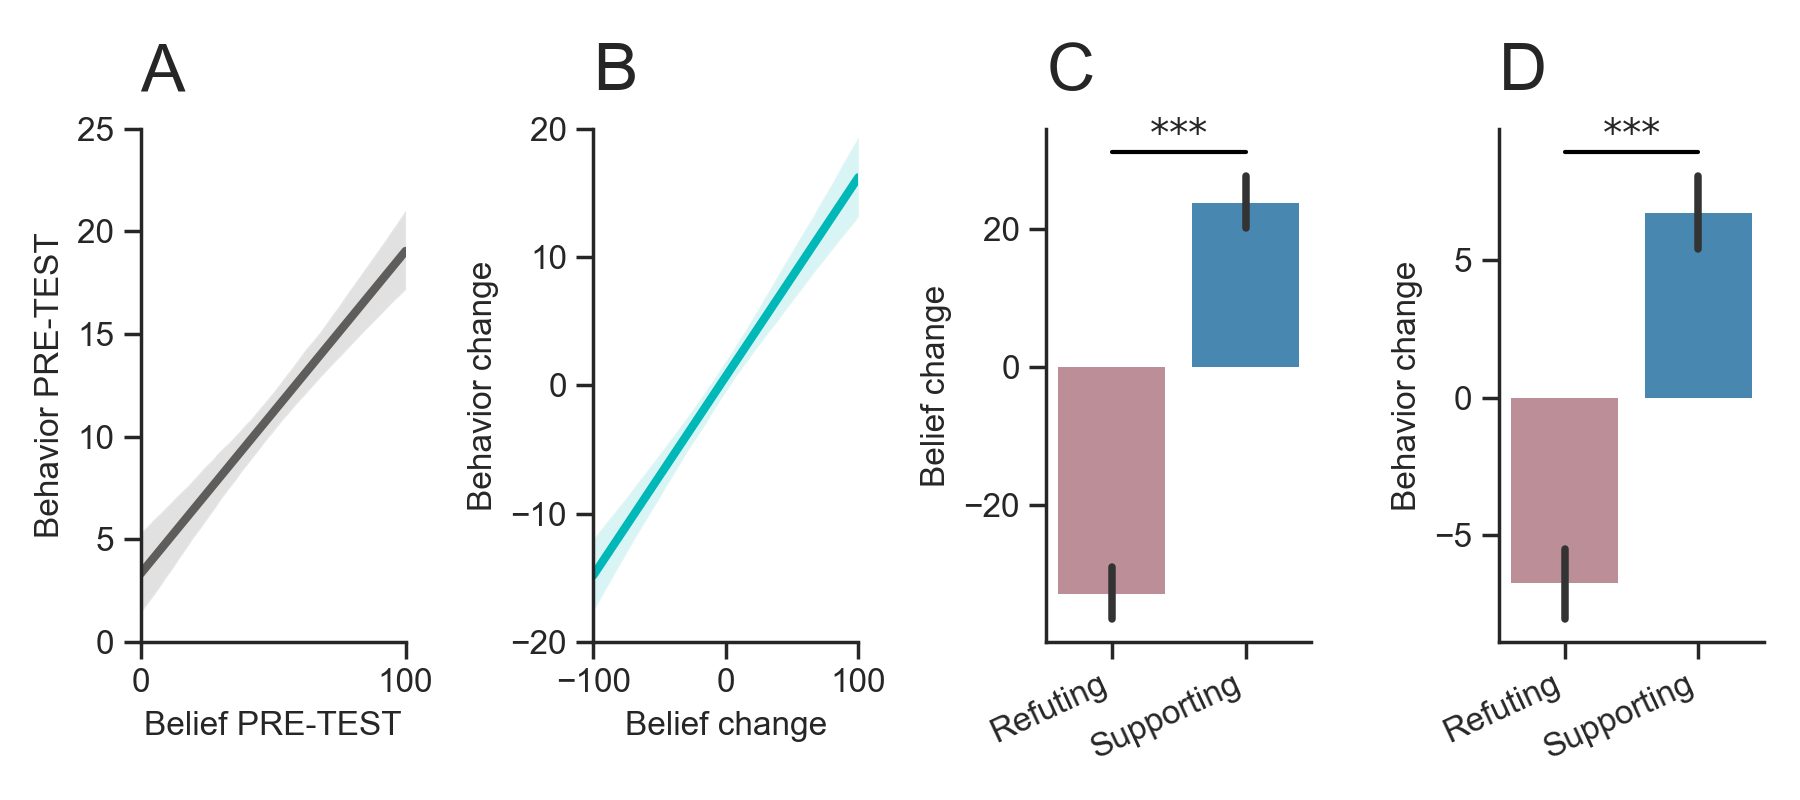

In [30]:
pal1 = ["#C48793", "#368BC1"]
pal = ["#C48793", "#368BC1"]

fig, ax = plt.subplots(1,4, figsize=(9,4))

sns.regplot(x=DATA.BeliefPRE, y=DATA.ChoicePRE, scatter_kws={"s": 0}, \
            line_kws={"color":"#3D3C3A","alpha":.8,"lw":3}, ax=ax[0])
ax[0].set_ylim(0,25)
ax[0].set_ylabel("Behavior PRE-TEST")
ax[0].set_xlabel("Belief PRE-TEST")
bff.panellabel(ax[0], "A")


sns.regplot(x=DATA.deltaB, y=DATA.deltaC, scatter_kws={"s": 0}, \
            line_kws={"color":"#00B8B8","alpha":1,"lw":3}, ax=ax[1])
ax[1].set_ylim(-20,20)
ax[1].set_ylabel("Behavior change")
ax[1].set_xlabel("Belief change")
bff.panellabel(ax[1], "B")


sns.barplot(x="IncDec", y="Bchange", data=df2, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2]) 
sns.despine()
ax[2].set_xlabel("");
ax[2].set_xticklabels(['Refuting', "Supporting"], rotation=25, ha="right")
ax[2].set_ylabel("Belief change");
datahandles = np.array([L.get_xydata() for L in ax[2].get_lines()])
_, p = stats.ttest_rel(df2.loc[df2["IncDec"]==0, "Bchange"], \
                       df2.loc[df2["IncDec"]==1, "Bchange"])
bff.barplot_annotate_brackets(ax[2], 0, 1, p, datahandles, dh=0.05, fs=14)
bff.panellabel(ax[2], "C")


sns.barplot(x="IncDec", y="Cchange", data=df2, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[3]) 
sns.despine()
ax[3].set_xlabel("");
ax[3].set_xticklabels(['Refuting', "Supporting"], rotation=25, ha="right")
ax[3].set_ylabel("Behavior change");
datahandles = np.array([L.get_xydata() for L in ax[3].get_lines()])
_, p = stats.ttest_rel(df2.loc[df2["IncDec"]==0, "Cchange"], \
                       df2.loc[df2["IncDec"]==1, "Cchange"])
bff.barplot_annotate_brackets(ax[3], 0, 1, p, datahandles, dh=0.05, fs=14)
bff.panellabel(ax[3], "D")
plt.tight_layout()
plt.savefig('figNSF.jpg', dpi=900, format="jpg")

<IPython.core.display.Javascript object>


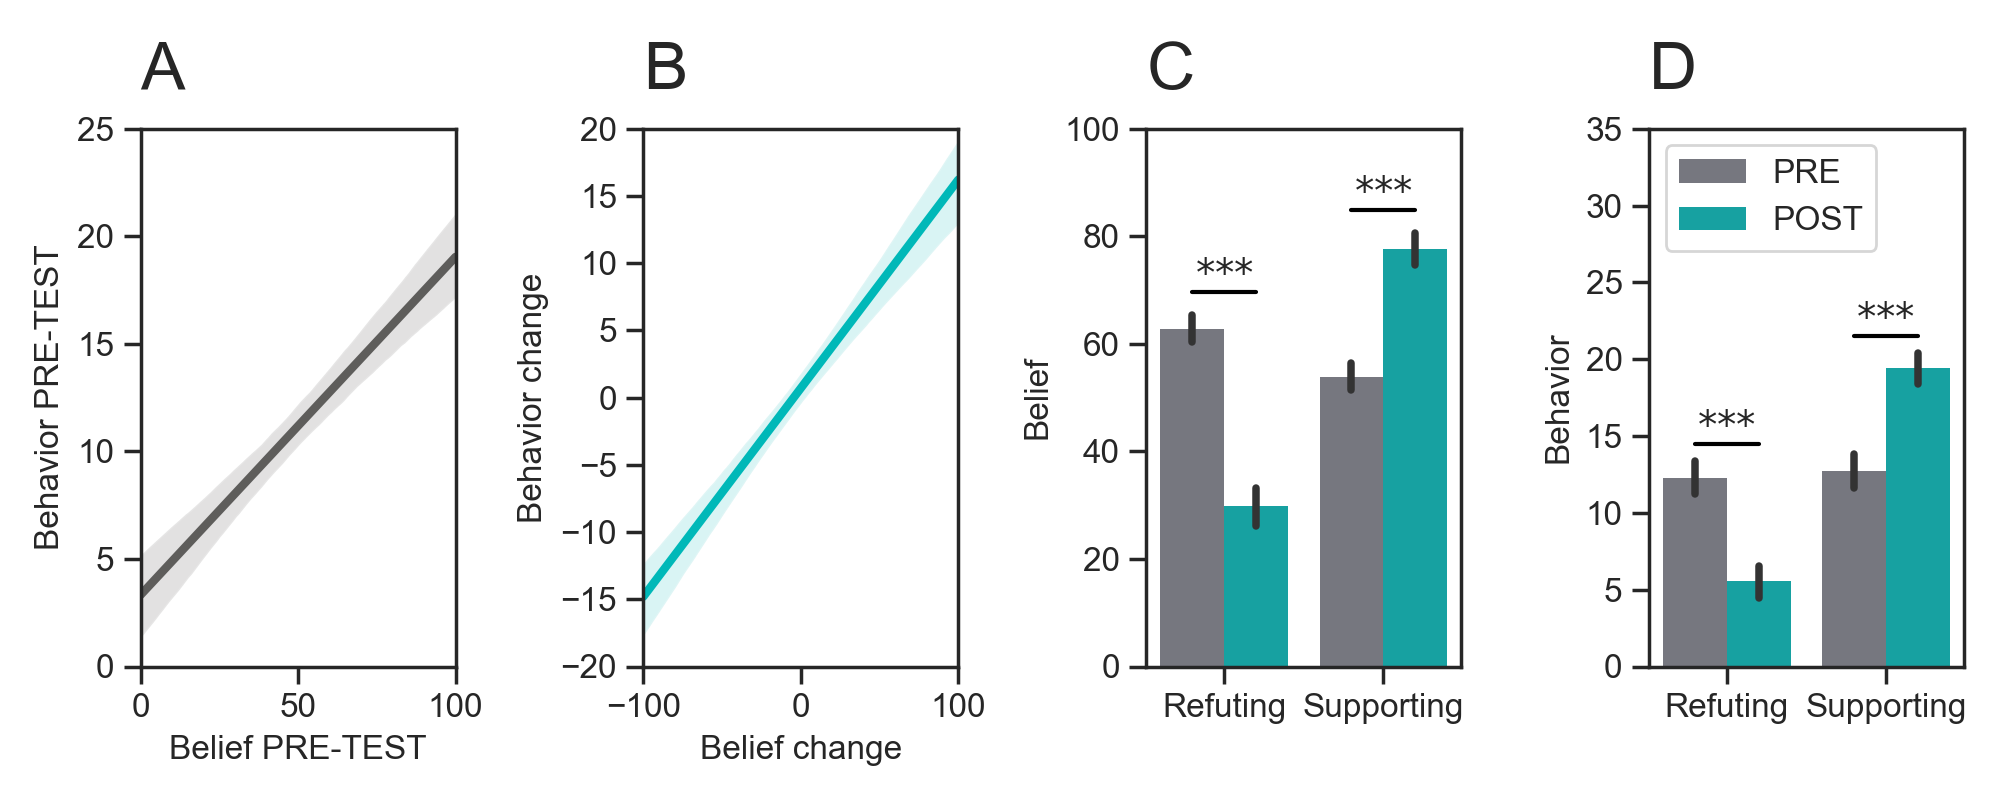

In [31]:
fig, ax = plt.subplots(1,4, figsize=(10,4))

sns.regplot(x=DATA.BeliefPRE, y=DATA.ChoicePRE, scatter_kws={"s": 0}, \
            line_kws={"color":"#3D3C3A","alpha":.8,"lw":3}, ax=ax[0])
ax[0].set_ylim(0,25)
ax[0].set_ylabel("Behavior PRE-TEST")
ax[0].set_xlabel("Belief PRE-TEST")
bff.panellabel(ax[0], "A")


sns.regplot(x=DATA.deltaB, y=DATA.deltaC, scatter_kws={"s": 0}, \
            line_kws={"color":"#00B8B8","alpha":1,"lw":3}, ax=ax[1])
ax[1].set_ylim(-20,20)
ax[1].set_ylabel("Behavior change")
ax[1].set_xlabel("Belief change")
bff.panellabel(ax[1], "B")

pal1 = ["#747681", "#00B8B8"]

tmp = pd.melt(df2, id_vars=['IncDec'], value_vars=['BeliefPRE', 'BeliefPOST'],
                   var_name='PrePost', value_name='Belief')


sns.barplot(x="IncDec", y="Belief", hue="PrePost", data=tmp, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2])
datahandles = np.array([L.get_xydata() for L in ax[2].get_lines()])
_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="BeliefPRE"), "Belief"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="BeliefPOST"), "Belief"])
bff.barplot_annotate_brackets(ax[2], 0, 2, p, datahandles, dh=0.05, fs=14)
_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="BeliefPRE"), "Belief"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="BeliefPOST"), "Belief"])
bff.barplot_annotate_brackets(ax[2], 1, 3, p, datahandles, dh=0.05, fs=14)
ax[2].set_xticklabels(['Refuting', "Supporting"])
ax[2].set_xlabel("")
ax[2].set_ylim([0,100])
ax[2].get_legend().remove()
bff.panellabel(ax[2], "C")

tmp = pd.melt(df2, id_vars=['IncDec'], value_vars=['ChoicePRE', 'ChoicePOST'],
                   var_name='PrePost', value_name='Choice')

sns.barplot(x="IncDec", y="Choice", hue="PrePost", data=tmp, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[3]) 
ax[3].get_legend().remove()
ax[3].legend(ax[3].patches[0:3:2], ['PRE', 'POST'], loc="upper left")
datahandles = np.array([L.get_xydata() for L in ax[3].get_lines()])
_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="ChoicePRE"), "Choice"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="ChoicePOST"), "Choice"])
bff.barplot_annotate_brackets(ax[3], 0, 2, p, datahandles, dh=0.05, fs=14)

_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="ChoicePRE"), "Choice"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="ChoicePOST"), "Choice"])
bff.barplot_annotate_brackets(ax[3], 1, 3, p, datahandles, dh=0.05, fs=14)
ax[3].set_xticklabels(['Refuting', "Supporting"])
ax[3].set_xlabel("")
ax[3].set_ylabel("Behavior")
ax[3].set_ylim([0,35])
bff.panellabel(ax[3], "D")
plt.tight_layout()
plt.savefig('figNSF.jpg', dpi=200, format="jpg")

In [32]:
tmp.loc[tmp["IncDec"]==1, :].head()

,IncDec,PrePost,Choice
0,1,ChoicePRE,13.75
1,1,ChoicePRE,17.50
2,1,ChoicePRE,25.00
3,1,ChoicePRE,15.00
4,1,ChoicePRE,25.00


In [33]:
%R library('mediation')

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: sandwich

R[write to console]: mediation: Causal Mediation Analysis
Version: 4.5.0




array(['mediation', 'sandwich', 'mvtnorm', 'MASS', 'MuMIn', 'lmerTest',
       'lme4', 'Matrix', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [34]:
%Rpush df2

In [35]:
pg.mediation_analysis(data=df2, x='IncDec', m='Bchange', y='Cchange', seed=42, n_boot=1000)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,Bchange ~ X,56.7814,2.6669,6.530704e-66,51.5369,62.0260,Yes
1,Y ~ Bchange,0.1674,0.0128,2.889014e-32,0.1422,0.1925,Yes
2,Total,13.4617,0.9502,1.361265e-36,11.5931,15.3304,Yes
3,Direct,8.8886,1.3889,4.813997e-10,6.1572,11.6199,Yes
4,Indirect,4.5732,0.9657,0.000000e+00,2.4707,6.2956,Yes


In [36]:
%%R

M <- lm(Cchange ~ IncDec, subject='partnum', data = df2)
summary(M)


Call:
lm(formula = Cchange ~ IncDec, data = df2, subject = "partnum")

Residuals:
    Min      1Q  Median      3Q     Max 
-31.731  -6.731   0.000   6.731  31.731 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.7309     0.6719  -10.02   <2e-16 ***
IncDec       13.4617     0.9502   14.17   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.09 on 364 degrees of freedom
Multiple R-squared:  0.3554,	Adjusted R-squared:  0.3536 
F-statistic: 200.7 on 1 and 364 DF,  p-value: < 2.2e-16



In [37]:
%%R

M <- lm(Bchange ~ IncDec, subject='partnum', data = df2)
summary(M)


Call:
lm(formula = Bchange ~ IncDec, data = df2, subject = "partnum")

Residuals:
    Min      1Q  Median      3Q     Max 
-74.581 -17.073  -0.081  16.951  56.951 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -32.951      1.886  -17.47   <2e-16 ***
IncDec        56.781      2.667   21.29   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25.51 on 364 degrees of freedom
Multiple R-squared:  0.5546,	Adjusted R-squared:  0.5534 
F-statistic: 453.3 on 1 and 364 DF,  p-value: < 2.2e-16



In [38]:
%%R

M <- lm(Cchange ~ IncDec + Bchange, subject='partnum', data = df2)
summary(M)


Call:
lm(formula = Cchange ~ IncDec + Bchange, data = df2, subject = "partnum")

Residuals:
    Min      1Q  Median      3Q     Max 
-32.630  -6.116   0.561   6.131  33.466 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.07701    0.88877  -4.587 6.19e-06 ***
IncDec       8.88857    1.38894   6.400 4.81e-10 ***
Bchange      0.08054    0.01822   4.421 1.30e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.867 on 363 degrees of freedom
Multiple R-squared:  0.3883,	Adjusted R-squared:  0.385 
F-statistic: 115.2 on 2 and 363 DF,  p-value: < 2.2e-16



In [39]:
%%R
?mediate
fitM <- lm(Bchange ~ IncDec,     data=df2) #IV on M; Hours since dawn predicting coffee consumption
fitY <- lm(Cchange ~ IncDec + Bchange, data=df2) #IV and M on DV; Hours since dawn and coffee predicting wakefulness
fitM


Call:
lm(formula = Bchange ~ IncDec, data = df2)

Coefficients:
(Intercept)       IncDec  
     -32.95        56.78  



In [40]:
%%R
fitY


Call:
lm(formula = Cchange ~ IncDec + Bchange, data = df2)

Coefficients:
(Intercept)       IncDec      Bchange  
   -4.07701      8.88857      0.08054  



In [41]:
%%R
fitMed <- mediate(fitM, fitY, treat="IncDec", mediator="Bchange")
summary(fitMed)


Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME              4.626        2.585         6.68  <2e-16 ***
ADE               8.881        6.038        11.70  <2e-16 ***
Total Effect     13.507       11.540        15.40  <2e-16 ***
Prop. Mediated    0.348        0.192         0.51  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 366 


Simulations: 1000 



In [ ]:
%%R
#Bootstrap
fitMedBoot <- mediate(fitM, fitY, boot=TRUE, sims=10000, treat="IncDec", mediator="Bchange")
summary(fitMedBoot)

R[write to console]: Running nonparametric bootstrap


